In this project we will create a convolutional neural network while will be able to predict whether a plant is suffering from disease. We will use different layers and other hyperparameter for building, training and testing this classification model. we will be using tensorflow and keras for this project.

In [2]:
# Load the drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


First we will mount our google drive on colab so that we can use the dataset directly from our drive. For this you first need to upload the data on your drive and then mount the drive on colab.

In [3]:
# After executing  the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

'Colab Notebooks'  'Important Documents'  'Sunny Paul.gsite'
 content	   'Personal Pictures'	  'University Mittweida.gdoc'


After mounting our drive we will locate the folder where our data is stored to use it in our colab notebook. Here you can see that I have 4 folders in my drive and content folder contain the data

In [4]:
# importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random 
import os
from os import listdir
from PIL import Image 
from sklearn.preprocessing import label_binarize, LabelBinarizer
from keras_preprocessing import image 
from keras_preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense 
from sklearn.model_selection import train_test_split 
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical  

Now we will observe some of the images that are their in our data set. we will plot 12 images here using the matplotlib library.

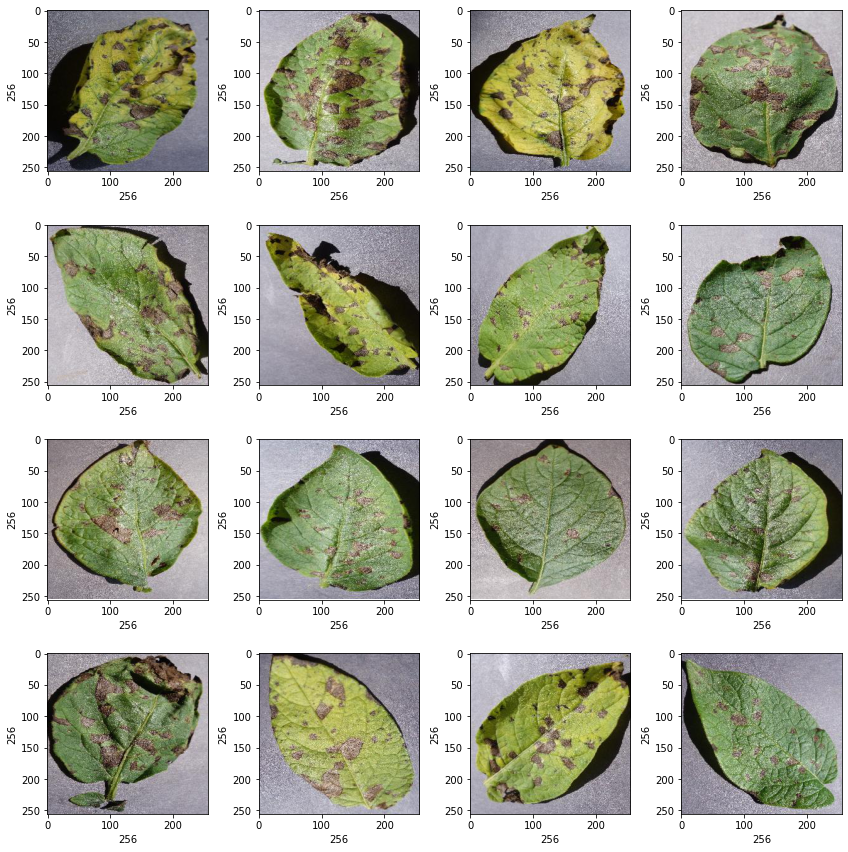

In [5]:
# Plotting 12 images to check dataset 
plt.figure(figsize=(12,12))
path = "/content/drive/My Drive/content/drive/plant_diseases/Plant_images_pianalytix/Potato___Early_blight"
for i in range(1, 17):
  plt.subplot(4,4,i)
  plt.tight_layout()
  rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize = 10) #width of image
  plt.ylabel(rand_img.shape[0], fontsize = 10) #height of image 

After visualizing the images let us move forward and create a function which will convert the images into numpy array. it is required because we will normalize our data set ofter this. 

In [6]:
# Converting Images to array 

def convert_image_to_array(image_dir):
  try:
    image = cv2.imread(image_dir)
    if image is not None :
      image = cv2.resize(image, (256, 256))
      #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      return img_to_array(image)
    else : 
      return np.array([])
  except Exception as e:
    print(f"Error : {e}")
    return None 

Now we will convert all the images into numpy array

In [7]:
dir = "/content/drive/My Drive/content/drive/plant_diseases/Plant_images_pianalytix"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1 

# Reading and Converting image to numpy array 
for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1 
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

We will also observe the number of images under different classes to see if the dataset is balanced of not

In [8]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

2    300
1    300
0    300
dtype: int64

In [9]:
# observe the shape of this images

image_list[0].shape

(256, 256, 3)

In [10]:
# checking the total number of the images which is the lenght of the label list

label_list = np.array(label_list)
label_list.shape

(900,)

Next we will use sklearn train_test_split to split the dataset into testing and training data. Here I have taken test size as 0.2 so my data will be divided  into 80% training and 20 % testing data 

In [11]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size = 0.2, random_state = 10)

Now we will normalize the dataset of our images. As pixel values ranges from 0 to 255 so we will divide each image pixel with 255 to normalize the dataset 

In [12]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0 
x_train = x_train.reshape(-1, 256, 256, 3)
x_test = x_test.reshape(-1, 256, 256, 3)

In [13]:
# convert the data into categorical data using one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test) 

Next we will create a network architechture for the model. we have used different types of layers according to their features namely Conv_2d ( it is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (it is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten ( it flattens the input and creates a 1D output), Dense( Dense layer produce the output as the dot product of input and kernel). 

In [14]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding = "same", input_shape=(256, 256, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, (3, 3), padding="same", activation ="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 112896)            0         
                                                                 
 dense (Dense)               (None, 64)                7

while compiling the model we need to set the type of loss which will be Binary Crossentropy for our model alongwith this we also need to set the optimizer and the metrics respectively.

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics = ['accuracy'])

Now we will split the dataset into validation and training data.

In [16]:
# Splitting the training data set into training and validation data sets

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

Fitting the model with the data and finding out the accuracy at each epoch to see how our model is learning. Now we will train our model on 10 epochs and a batch size of 128. you can try using more number of epochs to increase accuracy but here we can see that the model has already reached a very high accuracy so we don't need to run it for more. During each epochs we can see how the model is performing by viewing the training and validation accuracy. 

In [17]:
# training the model

epochs = 50 
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/50
5/5 [==============================] - 13s 577ms/step - loss: 0.8842 - accuracy: 0.5260 - val_loss: 0.5868 - val_accuracy: 0.6389
Epoch 2/50
5/5 [==============================] - 1s 229ms/step - loss: 0.4331 - accuracy: 0.8681 - val_loss: 0.3736 - val_accuracy: 0.8611
Epoch 3/50
5/5 [==============================] - 1s 225ms/step - loss: 0.2736 - accuracy: 0.9375 - val_loss: 0.2602 - val_accuracy: 0.9236
Epoch 4/50
5/5 [==============================] - 1s 232ms/step - loss: 0.1931 - accuracy: 0.9462 - val_loss: 0.2097 - val_accuracy: 0.9514
Epoch 5/50
5/5 [==============================] - 1s 232ms/step - loss: 0.1812 - accuracy: 0.9375 - val_loss: 0.1604 - val_accuracy: 0.9375
Epoch 6/50
5/5 [==============================] - 1s 228ms/step - loss: 0.1253 - accuracy: 0.9670 - val_loss: 0.2439 - val_accuracy: 0.8819
Epoch 7/50
5/5 [==============================] - 1s 229ms/step - loss: 0.1154 - accuracy: 0.9653 - val_loss: 0.1162 - val_accuracy: 0.9583
Epoch 8/50
5/5 [===

Saving the model using different techniques.

In [18]:
model.save("/content/drive/My Drive/content/drive/plant_diseases/Plant_images_pianalytix/plant_disease.h5")

#serialize model to json 
json_model = model.to_json()

#save the model architecture to json file
with open('/content/drive/My Drive/content/drive/plant_diseases/Plant_images_pianalytix/plant_model.json', 'w') as json_file:
  json_file.write(json_model)

#saving the weights of the model 
model.save_weights('/content/drive/My Drive/content/drive/plant_diseases/Plant_images_pianalytix/plant_model_weights.h5')

Next we will plot the accuracy of the model for the training history

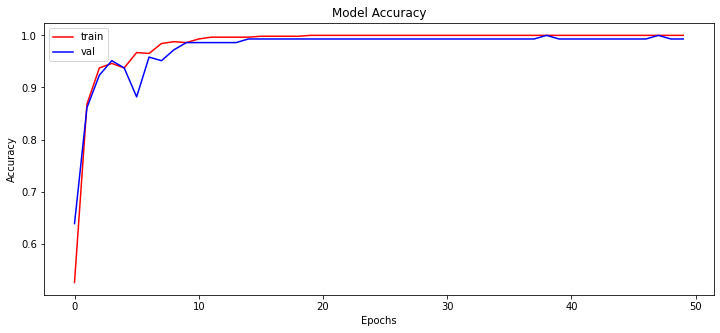

In [19]:
#plot the training history

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color ='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Evaluate the model to know the accuracy of the model

In [20]:
print("[INFO] Calculating model accuracy")
score = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {score[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 1s 73ms/step - loss: 0.0255 - accuracy: 0.9833
Test Accuracy: 98.33333492279053


Now we will use our model to predict predicting the testing dataset label

In [21]:
y_pred = model.predict(x_test)

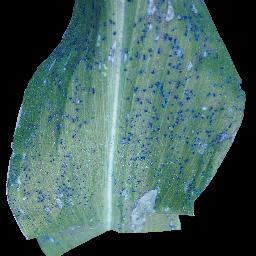

In [22]:
# plotting image to compare

img = array_to_img(x_test[10])
img

In [23]:
#finding the max value from prediction list and comparing original value vs predicted

print("Originally : ", all_labels[np.argmax(y_test[10])])

print("Predicted : ", all_labels[np.argmax(y_pred[10])])

Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight


**Conclusion** 
we started with loading the dataset into google colab using google drive and visualizing the images. Normalizing is an important step when working with any type of dataset. After that we created a CNN Model Which is further used for predicting the plant disease using the image supplied to model. This modelis highly beneficial as it can be used by different agriculture firms and farmers to increase their yield and stop wastage of crops due to disease.